#1.Preperation

In [ ]:
# Some imports that you might need
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go

import os

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import torch 
from torchvision.datasets.utils import download_url
import torchvision as tv
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from torch.utils.data import Dataset, DataLoader, IterableDataset

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

{}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle competitions download -c cassava-leaf-disease-classification

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.9/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.9/dist-packages/kaggle/api/kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
!unzip /content/cassava-leaf-disease-classification.zip

unzip:  cannot find or open /content/cassava-leaf-disease-classification.zip, /content/cassava-leaf-disease-classification.zip.zip or /content/cassava-leaf-disease-classification.zip.ZIP.


For the data, you need to agree to the terms and conditions to the Kaggle competition and click download all at https://www.kaggle.com/competitions/cassava-leaf-disease-classification/data.

You can choose to store the data in your google drive and mount your drive for accessing them from the following cell.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Remeber to change the path here for the corresponding files you need
train = pd.read_csv('train.csv')
test = pd.read_csv('sample_submission.csv')
label_map = pd.read_json('label_num_to_disease_map.json', 
                         orient='index')
display(train.head())
display(test.head())
display(label_map)

FileNotFoundError: ignored

In [ ]:
train.iloc[0]['image_id']

'1000015157.jpg'

In [ ]:
len(train)

21397

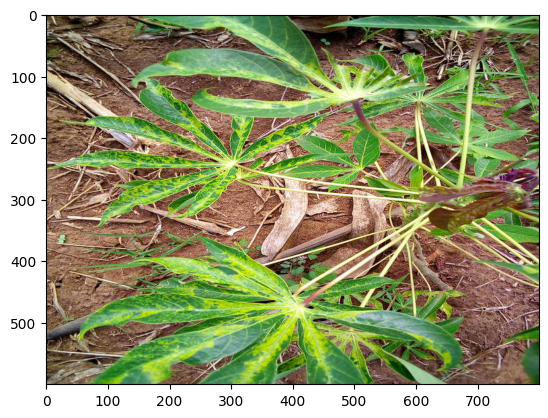

In [ ]:
sample_img = Image.open('train_images/1000201771.jpg')
plt.imshow(sample_img)


In [ ]:
np.array(sample_img).shape

(600, 800, 3)

In [ ]:
class ImageDataset(Dataset):
  def __init__(self, data_df, images_dir, transform):
    self.data_df = data_df
    self.images_dir = images_dir
    self.transform = transform

  def __len__(self):
    return len(self.data_df)

  def __getitem__(self, idx):
    image = Image.open(self.images_dir + '/' + train.iloc[idx]['image_id'])
    x = self.transform(image)
    y = train.iloc[idx]['label']
    return x, y


In [ ]:
transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
train_dataset = ImageDataset(train.iloc[:int(len(train)*0.8)], 'train_images', transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = ImageDataset(train.iloc[int(len(train)*0.8):], 'train_images', transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

#2.Models

In [ ]:
def train_model(train_loader, model, optimizer, criterion, epoch):
    model.train()
    model.cuda()
    for _iter in range(epoch):
        for i_batch, data_batch in enumerate(train_loader):
                      
            x_batch = data_batch[0].float().cuda()
            y_batch = data_batch[1].cuda()
               
            output = model(x_batch)
            loss = criterion(output, y_batch)
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print('iter: ', _iter, ' loss: ', loss.item())

In [ ]:
def eval(test_loader, model):
    model.eval()
    model.cuda()
    correct = 0
    total = 0
    for i_batch, data_batch in enumerate(test_loader):
                  
        x_batch = data_batch[0].float().cuda()
        y_batch = data_batch[1].cuda()
            
        output = model(x_batch)
        preds = torch.argmax(output, dim=1)

        correct += torch.sum(preds == y_batch)
        total += x_batch.shape[0]
    
    return correct / total

##Pretrained CNN

In [ ]:
#vgg19 = torch.hub.load('pytorch/vision:v0.10.0', 'vgg19', pretrained=False).cuda()
#alexnet = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=False).cuda()
#resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True).cuda()

In [ ]:
def set_parameter_no_grad(model):
    for param in model.parameters():
        param.requires_grad = False

In [ ]:
#set_parameter_no_grad(resnet)
#resnet.fc = nn.Linear(2048, 5)

In [ ]:
#epoch = 3
#lr = 1e-3

#optimizer = optim.Adam(resnet.parameters(), lr=lr)
#criterion = nn.CrossEntropyLoss()

#train_model(train_loader, resnet, optimizer, criterion, epoch)


In [ ]:
#eval(test_loader, resnet)

##Simple CNN

To optimize the Simple CNN
1. Add Batch Normalization:
Batch normalization can help improve the training process by normalizing the inputs of each layer, reducing internal covariate shift. This often leads to faster training and improved generalization

2. Add Dropout:
Dropout is a regularization technique that helps prevent overfitting by randomly "dropping" units from the network during training. This encourages the model to rely less on individual units and be more robust.

3. Adjust Hyperparameters:
Experiment with different hyperparameter settings such as kernel size, stride, and the number of filters (out_channels) in the convolutional layers to find the optimal configuration for your problem. Use techniques like grid search or random search to explore different combinations efficiently.





In [ ]:
import torch
import torch.nn as nn

class OptimizedCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=11, stride=1)
        self.bn1 = nn.BatchNorm2d(10)
        self.relu1 = nn.ReLU()
        self.mp1 = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout2d(0.25)

        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(20)
        self.relu2 = nn.ReLU()
        self.mp2 = nn.MaxPool2d(kernel_size=2)
        self.dropout2 = nn.Dropout2d(0.25)

        self.conv3 = nn.Conv2d(in_channels=20, out_channels=20, kernel_size=3, stride=2)
        self.bn3 = nn.BatchNorm2d(20)
        self.relu3 = nn.ReLU()
        self.mp3 = nn.MaxPool2d(kernel_size=2)
        self.dropout3 = nn.Dropout(0.5)

        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(nn.Linear(in_features=720, out_features=256),
                                nn.ReLU(),
                                nn.Linear(256, 5))

    def forward(self, x):
        h1 = self.dropout1(self.mp1(self.relu1(self.bn1(self.conv1(x)))))
        h2 = self.dropout2(self.mp2(self.relu2(self.bn2(self.conv2(h1)))))
        h3 = self.dropout3(self.mp3(self.relu3(self.bn3(self.conv3(h2)))))
        outputs = self.fc(self.flatten(h3))
        return outputs


In [ ]:
epoch = 5
lr = 1e-3

cnn = CNN()
optimizer = optim.Adam(cnn.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

train_model(train_loader, cnn, optimizer, criterion, epoch)

In [ ]:
eval(test_loader, cnn)

## VGG 16

VGG16 is a convolutional neural network (CNN) architecture proposed by Karen Simonyan and Andrew Zisserman from the Visual Geometry Group at the University of Oxford. It was introduced in their 2014 paper "Very Deep Convolutional Networks for Large-Scale Image Recognition." The '16' in VGG16 represents the number of weight layers in the network, which includes 13 convolutional layers and 3 fully connected layers.

VGG16 gained popularity due to its simplicity, ease of implementation, and outstanding performance in the ImageNet Large Scale Visual Recognition Challenge (ILSVRC) in 2014. It was one of the top-performing models in the competition, with a top-5 error rate of just 7.3%.

Simplicity: VGG16 uses small (3x3) convolutional filters throughout the entire architecture, which simplifies the network design and makes it easier to understand and implement. It employs a series of these small filters with increasing depth, resulting in a more straightforward model compared to other architectures with varying filter sizes and complex connections.

1. Excellent performance: VGG16 achieves state-of-the-art performance on various image classification tasks, including the ImageNet dataset. Its deep architecture allows it to learn complex hierarchical features, making it suitable for a wide range of applications.

2. Transfer learning: VGG16 has proven to be an excellent base model for transfer learning, where the pretrained weights of the model are fine-tuned for other image classification tasks. This approach significantly reduces training time and computational resources, as well as improves the performance of models in cases where the new task has limited training data.

3. Feature extraction: VGG16 can also be used as a feature extractor for other computer vision tasks, such as object detection and segmentation. The intermediate layers of the VGG16 model can be used to obtain rich feature representations, which can then be fed into other models or algorithms.






In [ ]:
#Define the VGG16
vgg16 = models.vgg16_bn(pretrained=True)


In [ ]:
#Edit it to adapt to our category number
num_classes = len(label_map)
vgg16.classifier[6] = nn.Linear(4096, num_classes)

In [ ]:
vgg16 = vgg16.to(device)

In [ ]:
#Train the model
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        print(f'Epoch {epoch + 1}, Loss: {running_loss / (i + 1)}')

print("Training Finished")


In [ ]:
#Test the model accuracy

correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on {total} test images: {100 * correct / total}%')


In [ ]:
# Visulization the result
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(test_loader)
images, labels = dataiter.next()


In [ ]:
# Esimate the model
images = images.to(device)
outputs = vgg16(images[:4])
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % label_map[predicted[j].item()].values[0] for j in range(4)))

##MLP

In [ ]:
class MLP(nn.Module):
        def __init__(self):
            super().__init__()

            self.flatten = nn.Flatten()
            self.fc = nn.Sequential(nn.Linear(in_features=3*224*224, out_features=2048),
                                    nn.ReLU(),
                                    nn.Linear(in_features=2048, out_features=1024),
                                    nn.ReLU(),
                                    nn.Linear(in_features=1024, out_features=256),
                                    nn.ReLU(),
                                    nn.Linear(in_features=256, out_features=5)
                                    )


        def forward(self, x):

            outputs = self.fc(self.flatten(x))

            return outputs

In [ ]:
print('MLP (3*224*224, 2048, 1024, 256, 5)')
for epoch in [3, 5]:
  for lr in [1e-4, 1e-3]:

    mlp = MLP()
    optimizer = optim.Adam(mlp.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    print(f'epoch={epoch}, lr={lr}')
    train_model(train_loader, mlp, optimizer, criterion, epoch)
    print(f'accuracy: {eval(test_loader, mlp)}')

MLP (3*224*224, 2048, 1024, 256, 5)
epoch=3, lr=0.0001
iter:  0  loss:  1.295581579208374
iter:  1  loss:  1.081681489944458
iter:  2  loss:  1.0750588178634644
accuracy: 0.693691611289978
epoch=3, lr=0.001
iter:  0  loss:  1.0516048669815063
iter:  1  loss:  1.0379126071929932
iter:  2  loss:  1.0632011890411377
accuracy: 0.6306074857711792
epoch=5, lr=0.0001
iter:  0  loss:  1.3076155185699463
iter:  1  loss:  0.9253133535385132
iter:  2  loss:  1.065185546875
iter:  3  loss:  1.0264722108840942
iter:  4  loss:  0.719407320022583
accuracy: 0.8957943916320801
epoch=5, lr=0.001
iter:  0  loss:  1.0695829391479492
iter:  1  loss:  1.2999106645584106
iter:  2  loss:  0.9377087950706482
iter:  3  loss:  1.0636699199676514
iter:  4  loss:  0.6439363360404968
accuracy: 0.707243025302887


In [ ]:
class MLP2(nn.Module):
        def __init__(self):
            super().__init__()

            self.flatten = nn.Flatten()
            self.fc = nn.Sequential(nn.Linear(in_features=3*224*224, out_features=256),
                                    nn.ReLU(),
                                    nn.Linear(in_features=256, out_features=128),
                                    nn.ReLU(),
                                    nn.Linear(in_features=128, out_features=64),
                                    nn.ReLU(),
                                    nn.Linear(in_features=64, out_features=32),
                                    nn.ReLU(),
                                    nn.Linear(in_features=32, out_features=5)
                                    )


        def forward(self, x):

            outputs = self.fc(self.flatten(x))

            return outputs

In [ ]:
print('MLP (3*224*224, 256, 128, 64, 32, 5)')
for epoch in [3, 5]:
  for lr in [1e-4, 1e-3]:

    mlp = MLP2()
    optimizer = optim.Adam(mlp.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    print(f'epoch={epoch}, lr={lr}')
    train_model(train_loader, mlp, optimizer, criterion, epoch)
    print(f'accuracy: {eval(test_loader, mlp)}')

MLP (3*224*224, 256, 128, 64, 32, 5)
epoch=3, lr=0.0001
iter:  0  loss:  0.977910578250885
iter:  1  loss:  0.9983242154121399
iter:  2  loss:  1.0561641454696655
accuracy: 0.6471962928771973
epoch=3, lr=0.001
iter:  0  loss:  1.2315561771392822
iter:  1  loss:  1.4567501544952393
iter:  2  loss:  0.9737745523452759
accuracy: 0.6420561075210571
epoch=5, lr=0.0001
iter:  0  loss:  1.2323380708694458
iter:  1  loss:  1.2410849332809448
iter:  2  loss:  1.232227087020874
iter:  3  loss:  0.9933124780654907
iter:  4  loss:  0.8314356803894043
accuracy: 0.8464953303337097
epoch=5, lr=0.001
iter:  0  loss:  1.1235679388046265
iter:  1  loss:  1.1720621585845947
iter:  2  loss:  1.1411463022232056
iter:  3  loss:  1.1890093088150024
iter:  4  loss:  0.8985083103179932
accuracy: 0.7142523527145386


##Vision Transformer

In [ ]:
%pip install timm
import timm


model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=5)

params_to_update = []
update_param_names = ['head.weight', 'head.bias']

for name, param in model.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
    else:
        param.requires_grad = False
        
lr = 1e-4
epoch = 3
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
print('vit_base_patch16_224（epoch=3）:')
train_model(train_loader, model, optimizer, criterion, epoch)
print(f'accuracy: {eval(test_loader, model)}')


In [ ]:

model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=5)

params_to_update = []
update_param_names = ['head.weight', 'head.bias']

for name, param in model.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
    else:
        param.requires_grad = False
        
lr = 1e-4
epoch = 5
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
print('vit_base_patch16_224（epoch=5）:')
train_model(train_loader, model, optimizer, criterion, epoch)
print(f'accuracy: {eval(test_loader, model)}')


In [ ]:
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=5)

params_to_update = []
update_param_names = ['head.weight', 'head.bias']

for name, param in model.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
    else:
        param.requires_grad = False
        
lr = 1e-4
epoch = 8
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
print('vit_base_patch16_224（epoch=8）:')
train_model(train_loader, model, optimizer, criterion, epoch)
print(f'accuracy: {eval(test_loader, model)}')

vit_base_patch16_224（epoch=8）:
iter:  0  loss:  0.8260169625282288
iter:  1  loss:  0.5839328765869141
iter:  2  loss:  0.51882004737854
iter:  3  loss:  0.6723348498344421
iter:  4  loss:  0.37493062019348145
iter:  5  loss:  0.4277806878089905
iter:  6  loss:  0.417275607585907
iter:  7  loss:  0.37502938508987427
accuracy: 0.8294392824172974


In [ ]:
model = timm.create_model('vit_base_patch32_224', pretrained=True, num_classes=5)

params_to_update = []
update_param_names = ['head.weight', 'head.bias']

for name, param in model.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
    else:
        param.requires_grad = False
        
lr = 1e-4
epoch = 3
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
print('vit_base_patch32_224(epoch=3):')
train_model(train_loader, model, optimizer, criterion, epoch)
print(f'accuracy: {eval(test_loader, model)}')

In [ ]:
params_to_update = []
update_param_names = ['head.weight', 'head.bias']

for name, param in model.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
    else:
        param.requires_grad = False
        
lr = 1e-4
epoch = 5
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
print('vit_base_patch32_224 (epoch=5):')
train_model(train_loader, model, optimizer, criterion, epoch)
print(f'accuracy: {eval(test_loader, model)}')

In [ ]:
params_to_update = []
update_param_names = ['head.weight', 'head.bias']

for name, param in model.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
    else:
        param.requires_grad = False
        
lr = 1e-4
epoch = 8
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
print('vit_base_patch32_224 (epoch=5):')
train_model(train_loader, model, optimizer, criterion, epoch)
print(f'accuracy: {eval(test_loader, model)}')

vit_base_patch32_224 (epoch=5):
iter:  0  loss:  0.39687854051589966
iter:  1  loss:  0.526298999786377
iter:  2  loss:  0.4867174029350281
iter:  3  loss:  0.5626655220985413
iter:  4  loss:  0.21927042305469513
iter:  5  loss:  0.7791145443916321
iter:  6  loss:  0.38067179918289185
iter:  7  loss:  0.547355055809021
accuracy: 0.814018726348877


In [ ]:
model = timm.create_model('vit_large_patch16_224', pretrained=True, num_classes=5)

params_to_update = []
update_param_names = ['head.weight', 'head.bias']

for name, param in model.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
    else:
        param.requires_grad = False
        
lr = 1e-4
epoch = 3
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
print('vit_large_patch16_224:')
train_model(train_loader, model, optimizer, criterion, epoch)
print(f'accuracy: {eval(test_loader, model)}')

In [ ]:
model = timm.create_model('vit_large_patch16_224', pretrained=True, num_classes=5)

params_to_update = []
update_param_names = ['head.weight', 'head.bias']

for name, param in model.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
    else:
        param.requires_grad = False
        
lr = 1e-4
epoch = 5
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
print('vit_large_patch16_224:')
train_model(train_loader, model, optimizer, criterion, epoch)
print(f'accuracy: {eval(test_loader, model)}')

vit_large_patch16_224:
iter:  0  loss:  0.6521955132484436
iter:  1  loss:  0.8752370476722717
iter:  2  loss:  0.5680178999900818
iter:  3  loss:  0.21562503278255463
iter:  4  loss:  0.6979325413703918
accuracy: 0.8308411240577698


In [ ]:
model = timm.create_model('vit_large_patch16_224', pretrained=True, num_classes=5)

params_to_update = []
update_param_names = ['head.weight', 'head.bias']

for name, param in model.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
    else:
        param.requires_grad = False
        
lr = 1e-4
epoch = 8
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
print('vit_large_patch16_224:')
train_model(train_loader, model, optimizer, criterion, epoch)
print(f'accuracy: {eval(test_loader, model)}')

vit_large_patch16_224:
iter:  0  loss:  1.0765100717544556
iter:  1  loss:  0.4316539764404297
iter:  2  loss:  0.5557053089141846
iter:  3  loss:  0.6754419803619385
iter:  4  loss:  0.5213037133216858
iter:  5  loss:  0.3230554759502411
iter:  6  loss:  0.5431394577026367
iter:  7  loss:  0.343441903591156
accuracy: 0.8443925380706787


##Contrastive Learning

###Two-Crop Transform

In [ ]:
class TwoCropTransform:
    """Create two crops of the same image"""
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, x):
        return [self.transform(x), self.transform(x)]


###Dataset

In [ ]:
class ContrastiveDataset(Dataset):
  def __init__(self, data_df, images_dir, transform):
    self.data_df = data_df
    self.images_dir = images_dir
    self.transform = transform

  def __len__(self):
    return len(self.data_df)

  def __getitem__(self, idx):
    image = Image.open(self.images_dir + '/' + train.iloc[idx]['image_id'])
    x1, x2 = self.transform(image)
    y = train.iloc[idx]['label']
    return x1, x2, y

###SupCon Loss

In [ ]:
class SupConLoss(nn.Module):
    """Supervised Contrastive Learning: https://arxiv.org/pdf/2004.11362.pdf.
    It also supports the unsupervised contrastive loss in SimCLR"""
    def __init__(self, temperature=0.07, contrast_mode='all',
                 base_temperature=0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature

    def forward(self, features, labels=None, mask=None):
        """Compute loss for model. If both `labels` and `mask` are None,
        it degenerates to SimCLR unsupervised loss:
        https://arxiv.org/pdf/2002.05709.pdf
        Args:
            features: hidden vector of shape [bsz, n_views, ...].
            labels: ground truth of shape [bsz].
            mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j
                has the same class as sample i. Can be asymmetric.
        Returns:
            A loss scalar.
        """
        device = (torch.device('cuda')
                  if features.is_cuda
                  else torch.device('cpu'))

        if len(features.shape) < 3:
            raise ValueError('`features` needs to be [bsz, n_views, ...],'
                             'at least 3 dimensions are required')
        if len(features.shape) > 3:
            features = features.view(features.shape[0], features.shape[1], -1)

        batch_size = features.shape[0]
        if labels is not None and mask is not None:
            raise ValueError('Cannot define both `labels` and `mask`')
        elif labels is None and mask is None:
            mask = torch.eye(batch_size, dtype=torch.float32).to(device)
        elif labels is not None:
            labels = labels.contiguous().view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            mask = torch.eq(labels, labels.T).float().to(device)
        else:
            mask = mask.float().to(device)

        contrast_count = features.shape[1]
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        # compute logits
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature)
        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        # tile mask
        mask = mask.repeat(anchor_count, contrast_count)
        # mask-out self-contrast cases
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask

        # compute log_prob
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))

        # compute mean of log-likelihood over positive
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)

        # loss
        loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.view(anchor_count, batch_size).mean()

        return loss

###ResNet

In [ ]:
"""ResNet in PyTorch.
ImageNet-Style ResNet
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
Adapted from: https://github.com/bearpaw/pytorch-classification
"""
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, is_last=False):
        super(BasicBlock, self).__init__()
        self.is_last = is_last
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        preact = out
        out = F.relu(out)
        if self.is_last:
            return out, preact
        else:
            return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, is_last=False):
        super(Bottleneck, self).__init__()
        self.is_last = is_last
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        preact = out
        out = F.relu(out)
        if self.is_last:
            return out, preact
        else:
            return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, in_channel=3, zero_init_residual=False):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(in_channel, 64, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves
        # like an identity. This improves the model by 0.2~0.3% according to:
        # https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for i in range(num_blocks):
            stride = strides[i]
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x, layer=100):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        return out


def resnet18(**kwargs):
    return ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)


def resnet34(**kwargs):
    return ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)


def resnet50(**kwargs):
    return ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)


def resnet101(**kwargs):
    return ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)


model_dict = {
    'resnet18': [resnet18, 512],
    'resnet34': [resnet34, 512],
    'resnet50': [resnet50, 2048],
    'resnet101': [resnet101, 2048],
}


class LinearBatchNorm(nn.Module):
    """Implements BatchNorm1d by BatchNorm2d, for SyncBN purpose"""
    def __init__(self, dim, affine=True):
        super(LinearBatchNorm, self).__init__()
        self.dim = dim
        self.bn = nn.BatchNorm2d(dim, affine=affine)

    def forward(self, x):
        x = x.view(-1, self.dim, 1, 1)
        x = self.bn(x)
        x = x.view(-1, self.dim)
        return x


class SupConResNet(nn.Module):
    """backbone + projection head"""
    def __init__(self, name='resnet50', head='mlp', feat_dim=128):
        super(SupConResNet, self).__init__()
        model_fun, dim_in = model_dict[name]
        self.encoder = model_fun()
        if head == 'linear':
            self.head = nn.Linear(dim_in, feat_dim)
        elif head == 'mlp':
            self.head = nn.Sequential(
                nn.Linear(dim_in, dim_in),
                nn.ReLU(inplace=True),
                nn.Linear(dim_in, feat_dim)
            )
        else:
            raise NotImplementedError(
                'head not supported: {}'.format(head))

    def forward(self, x):
        feat = self.encoder(x)
        feat = F.normalize(self.head(feat), dim=1)
        return feat


class SupCEResNet(nn.Module):
    """encoder + classifier"""
    def __init__(self, name='resnet50', num_classes=10):
        super(SupCEResNet, self).__init__()
        model_fun, dim_in = model_dict[name]
        self.encoder = model_fun()
        self.fc = nn.Linear(dim_in, num_classes)

    def forward(self, x):
        return self.fc(self.encoder(x))


class LinearClassifier(nn.Module):
    """Linear classifier"""
    def __init__(self, name='resnet50', num_classes=10):
        super(LinearClassifier, self).__init__()
        _, feat_dim = model_dict[name]
        self.fc = nn.Linear(feat_dim, num_classes)

    def forward(self, features):
        return self.fc(features)

###SupCon Model

In [ ]:
class SupConResNet(nn.Module):
    """backbone + projection head"""
    def __init__(self, temperature, name='resnet50', head='mlp', feat_dim=128, use_label=False):
        super(SupConResNet, self).__init__()
        #model_fun, dim_in = model_dict[name]
        dim_in = 2048
        self.encoder = resnet50()
        self.use_label = use_label
        if head == 'linear':
            self.head = nn.Linear(dim_in, feat_dim)
        elif head == 'mlp':
            self.head = nn.Sequential(
                nn.Linear(dim_in, dim_in),
                nn.ReLU(inplace=True),
                nn.Linear(dim_in, feat_dim)
            )
        else:
            raise NotImplementedError(
                'head not supported: {}'.format(head))
        self.critic = SupConLoss(temperature)

    def forward(self, x1, x2, y):
        feat1 = self.encoder(x1)
        feat1 = F.normalize(self.head(feat1), dim=1)

        feat2 = self.encoder(x2)
        feat2 = F.normalize(self.head(feat2), dim=1)

        feat = torch.cat([feat1.unsqueeze(1), feat2.unsqueeze(1)], dim=1)

        if self.use_label:
            loss = self.critic(feat, y)
        else:
            loss = self.critic(feat)

        return loss

    def get_embedding(self, x):
        return self.encoder(x)

###Training

In [ ]:
batch_size = 128
train_transform = T.Compose([
    T.RandomResizedCrop(size=32, scale=(0.2, 1.)),
    T.RandomHorizontalFlip(),
    T.RandomApply([
        T.ColorJitter(0.4, 0.4, 0.4, 0.1)
    ], p=0.8),
    T.RandomGrayscale(p=0.2),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
test_transform = T.Compose([
        T.Resize(size=32),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

two_crop_transform = TwoCropTransform(train_transform)



In [ ]:
train_dataset = ContrastiveDataset(train.iloc[:int(len(train)*0.8)], 'train_images', two_crop_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = ImageDataset(train.iloc[int(len(train)*0.8):], 'train_images', test_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
train_dataset[0][0].shape

torch.Size([3, 224, 224])

In [ ]:
def train_supcon(model, train_loader, optimizer, num_epoch=50, model_name='simclr'):
    for _iter in range(num_epoch):
        for i_batch, data_batch in enumerate(train_loader):
                      
            x1_batch = data_batch[0].float().cuda()
            x2_batch = data_batch[1].float().cuda()
            y_batch = data_batch[2].float().cuda()
               
            loss = model(x1_batch, x2_batch, y_batch)
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if i_batch % 10 == 0:
                print('epoch: ', _iter, ' i_batch: ', i_batch, ' loss: ', loss.item())
        if _iter % 10 == 0:
            print('------saving model checkpoint------')
            torch.save(model, f'{model_name}_model_{_iter}.pt')
    return

####SimCLR

In [ ]:
simclr = SupConResNet(0.7, use_label=False).cuda()
simclr_optim = optim.Adam(simclr.parameters())
train_supcon(simclr, train_loader, simclr_optim)

In [ ]:
train_dataset = ImageDataset(train.iloc[:int(len(train)*0.8)], 'train_images', test_transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

test_dataset = ImageDataset(train.iloc[int(len(train)*0.8):], 'train_images', test_transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [ ]:
torch.save(simclr, 'simclr.pt')

In [ ]:
simclr = torch.load('simclr.pt')

In [ ]:
from google.colab import files
files.download('simclr.pt') 

In [ ]:
from sklearn.linear_model import LogisticRegression

train_datas = [data for data in train_loader]
train_embeds = np.concatenate([simclr.get_embedding(data[0].cuda()).detach().cpu().numpy() for data in train_datas])
train_labels = np.concatenate([data[1].detach().cpu().numpy() for data in train_datas])

test_datas = [data for data in test_loader]
test_embeds = np.concatenate([simclr.get_embedding(data[0].cuda()).detach().cpu().numpy() for data in test_datas])
test_labels = np.concatenate([data[1].detach().cpu().numpy() for data in test_datas])

# Train Logistic Classifier
clf = LogisticRegression(max_iter=200).fit(train_embeds, train_labels)
score = clf.score(test_embeds, test_labels)
print(score)

####SupCon

In [ ]:
supcon = SupConResNet(0.7, use_label=True).cuda()
supcon_optim = optim.Adam(supcon.parameters())
train_supcon(supcon, train_loader, supcon_optim)

In [ ]:
torch.save(supcon, 'supcon.pt')

In [ ]:
from google.colab import files
files.download('supcon.pt') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
supcon = torch.load('supcon.pt')

In [ ]:
from sklearn.linear_model import LogisticRegression

train_datas = [data for data in train_loader]
train_embeds = np.concatenate([supcon.get_embedding(data[0].cuda()).detach().cpu().numpy() for data in train_datas])
train_labels = np.concatenate([data[1].detach().cpu().numpy() for data in train_datas])

test_datas = [data for data in test_loader]
test_embeds = np.concatenate([supcon.get_embedding(data[0].cuda()).detach().cpu().numpy() for data in test_datas])
test_labels = np.concatenate([data[1].detach().cpu().numpy() for data in test_datas])

# Train Logistic Classifier
clf = LogisticRegression(max_iter=200).fit(train_embeds, train_labels)
score = clf.score(test_embeds, test_labels)
print(score)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7946261682242991
